In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
df_1 = pd.read_csv('dataset/test.csv')
df_1['char_count'] = df_1['Description'].apply(len)
df_1 = df_1[df_1['Class Index'] != 4]

class_counts = df_1['Class Index'].value_counts()

# Randomly selecting 100 instances from each class
df = pd.DataFrame()

for class_index in class_counts.index:
    class_df = df_1[df_1['Class Index'] == class_index]

    #class_df = class_df.sort_values(by='char_count')

    selected_df = class_df.head(10)

    df = pd.concat([df, selected_df], ignore_index=True)

df = df.drop(columns=['Title'])
df = df.drop(columns=['char_count'])
df['ID'] = range(1, len(df) + 1)
df['Description'] = df['Description'].str.strip()
df['Description'] = df['Description'].str.replace(r'[^A-Za-z0-9\s]', '')
df['Description'] = df['Description'].str.lower()

df.head()

C:\Users\91900\AppData\Local\Temp\ipykernel_47788\2970360026.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Description'] = df['Description'].str.replace(r'[^A-Za-z0-9\s]', '')


Class Index                                        Description  ID
0            3  unions representing workers at turner   newall...   1
1            3  reuters  apparel retailers are hoping theirbac...   2
2            3  london reuters  the dollar dipped to a fourwee...   3
3            3  new york reuters  us treasury debt prices slip...   4
4            3  new york reuters  the dollar extended gains ag...   5

In [3]:
df.describe()

Class Index         ID
count    30.000000  30.000000
mean      2.000000  15.500000
std       0.830455   8.803408
min       1.000000   1.000000
25%       1.000000   8.250000
50%       2.000000  15.500000
75%       3.000000  22.750000
max       3.000000  30.000000

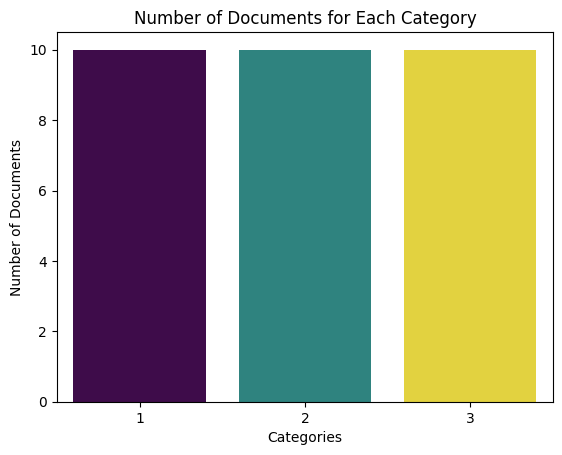

In [4]:
counts = df['Class Index'].value_counts()
sns.barplot(x=counts.index, y=counts.values, hue = counts.index, legend = False, palette='viridis')
plt.xlabel('Categories')
plt.ylabel('Number of Documents')
plt.title('Number of Documents for Each Category')
plt.show()

In [5]:
def create_shingles(df, k):
    shingles = set()
    for index, row in df.iterrows():
        description = row['Description']
        for i in range(len(description) - k + 1):
            shingle = description[i:i+k]
            shingles.add(shingle)
    return shingles

def shingles_per_row(text, k):
    shingle = []
    for i in range(len(text) - k + 1):
        shingle.append(text[i:i + k])
    return set(shingle)

In [6]:
df['shingles5'] = df['Description'].apply(lambda x: shingles_per_row(x, 5))
df['shingles10'] = df['Description'].apply(lambda x: shingles_per_row(x, 10))
df['shingles8'] = df['Description'].apply(lambda x: shingles_per_row(x, 8))

In [7]:
df.head()

Class Index                                        Description  ID  \
0            3  unions representing workers at turner   newall...   1   
1            3  reuters  apparel retailers are hoping theirbac...   2   
2            3  london reuters  the dollar dipped to a fourwee...   3   
3            3  new york reuters  us treasury debt prices slip...   4   
4            3  new york reuters  the dollar extended gains ag...   5   

                                           shingles5  \
0  {rm fe,  stri, rner , ral m, rs at, e dis, der...   
1  {and y, l fas, he gr,  fall, gstyl, young, epi...   
2  {ipped, king , ut st, ondon, ing s, ek lo,   t...   
3  {ipped, king , ental, racte, gh tr, uters,  se...   
4  {rrent, ed ga, e mon, he  e,  fore, o off, ns ...   

                                          shingles10  \
0  {after talk,  parent fi, irm federa, ointed af...   
1  {ters  appa, will make , his fall b, d young a...   
2  { a fourwee, il prices , slightly o, ta  conti...   
3  {rs charact, move as pr, ugh trader, gh trader...   
4  { to offset, n investme, extended g, fter a re...   

                                           shingles8  
0  {ers at t,  disappo, ting wor, e disapp, th st...  
1  {g adults,   appare, ions wil, ktoschoo, d on ...  
2  {ourweek , continue, low  aga,   the do, inued...  
3  { on  mon, ng  rath, prices s,  debt pr, york ...  
4  {york reu,   the do, t on flo, t the  e, uters...

In [8]:
def create_shingles_final(df):

    shingles_5 = create_shingles(df, 5)
    shingles_8 = create_shingles(df, 8)
    shingles_10 = create_shingles(df, 10)

    shingle_5_matrix = np.zeros((len(shingles_5), len(df)))
    shingle_8_matrix = np.zeros((len(shingles_8), len(df)))
    shingle_10_matrix = np.zeros((len(shingles_10), len(df)))

    for i, s in enumerate(shingles_5):
        for j in range(len(df)):
            if s in df['shingles5'][j]:
                shingle_5_matrix[i, j] = 1

    for i, s in enumerate(shingles_8):
        for j in range(len(df)):
            if s in df['shingles8'][j]:
                shingle_8_matrix[i, j] = 1

    for i, s in enumerate(shingles_10):
        for j in range(len(df)):
            if s in df['shingles10'][j]:
                shingle_10_matrix[i, j] = 1

    shingle_5_df = pd.DataFrame(shingle_5_matrix, index= list(shingles_5), columns=df.index)
    shingle_8_df = pd.DataFrame(shingle_8_matrix, index= list(shingles_8), columns=df.index)
    shingle_10_df = pd.DataFrame(shingle_10_matrix, index= list(shingles_10), columns=df.index)
    
    return shingle_5_df, shingle_8_df, shingle_10_df

In [9]:
shingle_5_df, shingle_8_df, shingle_10_df = create_shingles_final(df)

In [10]:
print(shingle_5_df.shape)
print(shingle_8_df.shape)
print(shingle_10_df.shape)

(4747, 30)
(5840, 30)
(5978, 30)


In [11]:
def min_hashing(shingle_df, percentage):
    # Number of hash functions
    num_hash_functions = int(shingle_df.shape[0] * percentage)
    hash_functions = [(np.random.randint(1, 100), np.random.randint(1, 100)) for _ in range(num_hash_functions)]
    signature_matrix = pd.DataFrame(np.inf, index=range(1, num_hash_functions + 1), columns=shingle_df.columns.difference(['Shingle']))
    shingle_index_map = {shingle: idx for idx, shingle in enumerate(shingle_df.index)}

    # Loop through the shingle dataframe
    for index, row in shingle_df.iterrows():
        for col in shingle_df.columns:
            if row[col] == 1:
                for i, (a, b) in enumerate(hash_functions, start=1):
                    hash_value = (a * shingle_index_map[index] + b) % shingle_df.shape[0]
                    signature_matrix.loc[i, col] = min(signature_matrix.loc[i, col], hash_value)

    return signature_matrix

In [12]:
def compute_signatures_matrices(shingle_5_df, shingle_8_df, shingle_10_df, percentage):

    signature_matrix_5 = min_hashing(shingle_5_df, percentage)
    signature_matrix_8 = min_hashing(shingle_8_df, percentage)
    signature_matrix_10 = min_hashing(shingle_10_df, percentage)
    
    return signature_matrix_5, signature_matrix_8, signature_matrix_10

In [53]:
def jaccard_similarity(signature_matrix, i, j):
    return np.sum(signature_matrix.loc[:, i] == signature_matrix.loc[:, j]) / np.sum(signature_matrix.loc[:, i])

In [54]:
def jaccard_similarity_column_numpy(shingle_df, i, j):
    
    intersection = np.sum((shingle_df[:, i] == shingle_df[:, j]) & (shingle_df[:, i] == 1))
    union = np.sum((shingle_df[:, i] == 1) | (shingle_df[:, j] == 1))

    if union == 0:
        return 0.0

    return intersection / union

In [48]:
signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10 = compute_signatures_matrices(shingle_5_df, shingle_8_df, shingle_10_df, 0.1)

KeyboardInterrupt: 

In [16]:
signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20 = compute_signatures_matrices(shingle_5_df, shingle_8_df, shingle_10_df, 0.2)

In [17]:
signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30 = compute_signatures_matrices(shingle_5_df, shingle_8_df, shingle_10_df, 0.3)

In [55]:
def plot_jaccard_similarity(numsize, sign_mat_5, sign_mat_8, sign_mat_10, classid, shingle_5_df, shingle_8_df, shingle_10_df):

    if classid == 1:
        random_numbers = np.random.choice(range(10), numsize, replace=False)
    elif classid == 2:
        random_numbers = np.random.choice(range(10, 20), numsize, replace=False)
    elif classid == 3:
        random_numbers = np.random.choice(range(20, 30), numsize, replace=False)
    else:
        random_numbers = np.random.choice(range(30), numsize, replace=False)

    jaccard_similarity_5 = np.zeros((numsize, numsize))
    jaccard_similarity_8 = np.zeros((numsize, numsize))
    jaccard_similarity_10 = np.zeros((numsize, numsize))
    column_similarity_5 = np.zeros((numsize, numsize))
    column_similarity_8 = np.zeros((numsize, numsize))
    column_similarity_10 = np.zeros((numsize, numsize))

    for i in range(numsize):
        for j in range(numsize):
            if i != j:
                num1 = random_numbers[i]
                num2 = random_numbers[j]
                jaccard_similarity_5[i, j] = jaccard_similarity(sign_mat_5, num1, num2)*10
                jaccard_similarity_8[i, j] = jaccard_similarity(sign_mat_8, num1, num2)
                jaccard_similarity_10[i, j] = jaccard_similarity(sign_mat_10, num1, num2)
                column_similarity_5[i, j] = jaccard_similarity_column_numpy(shingle_5_df.to_numpy(), num1, num2)
                column_similarity_8[i, j] = jaccard_similarity_column_numpy(shingle_8_df.to_numpy(), num1, num2)
                column_similarity_10[i, j] = jaccard_similarity_column_numpy(shingle_10_df.to_numpy(), num1, num2)

    
    jaccard_similarity_5 = jaccard_similarity_5.flatten()
    jaccard_similarity_8 = jaccard_similarity_8.flatten()
    jaccard_similarity_10 = jaccard_similarity_10.flatten()
    column_similarity_5 = column_similarity_5.flatten()
    column_similarity_8 = column_similarity_8.flatten()
    column_similarity_10 = column_similarity_10.flatten()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    axes[0].plot(jaccard_similarity_5, label='Jaccard Similarity (k = 5)')
    axes[0].plot(column_similarity_5, label='Column Similarity (k = 5)')
    axes[0].legend()

    axes[1].plot(jaccard_similarity_8, label='Jaccard Similarity (k = 8)')
    axes[1].plot(column_similarity_8, label='Column Similarity (k = 8)')
    axes[1].legend()

    axes[2].plot(jaccard_similarity_10, label='Jaccard Similarity (k = 10)')
    axes[2].plot(column_similarity_10, label='Column Similarity (k = 10)')
    axes[2].legend()

    plt.show()

# Analysis of similarity using Jaccard cofficient using 10% retention

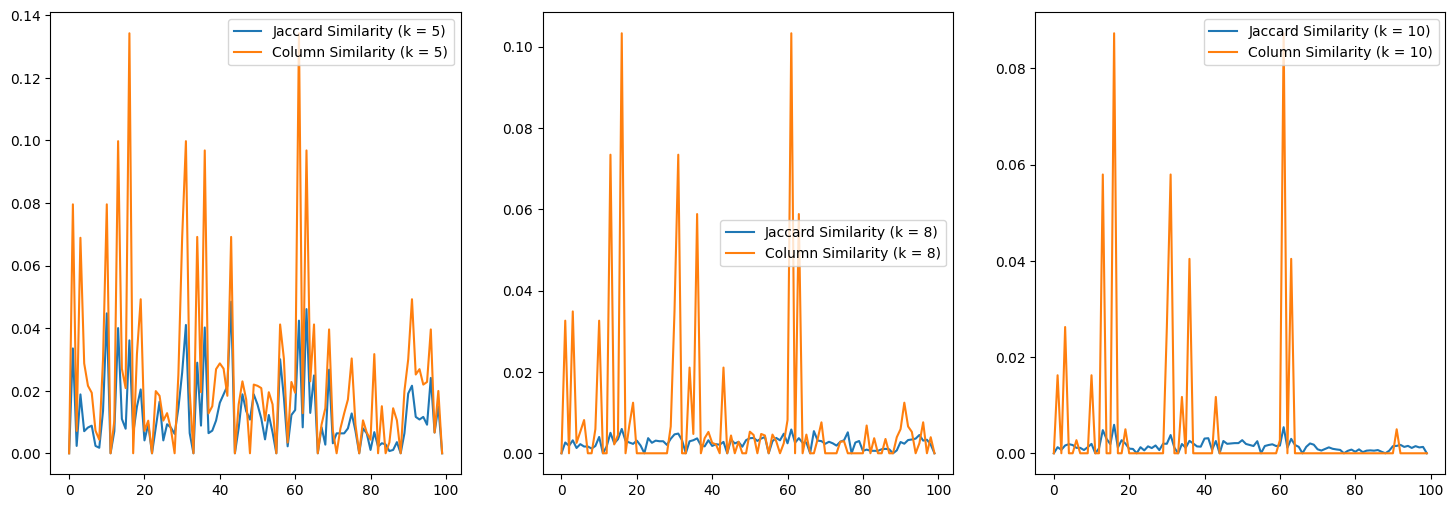

In [56]:
# World news
plot_jaccard_similarity(10, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 1, shingle_5_df, shingle_8_df, shingle_10_df)

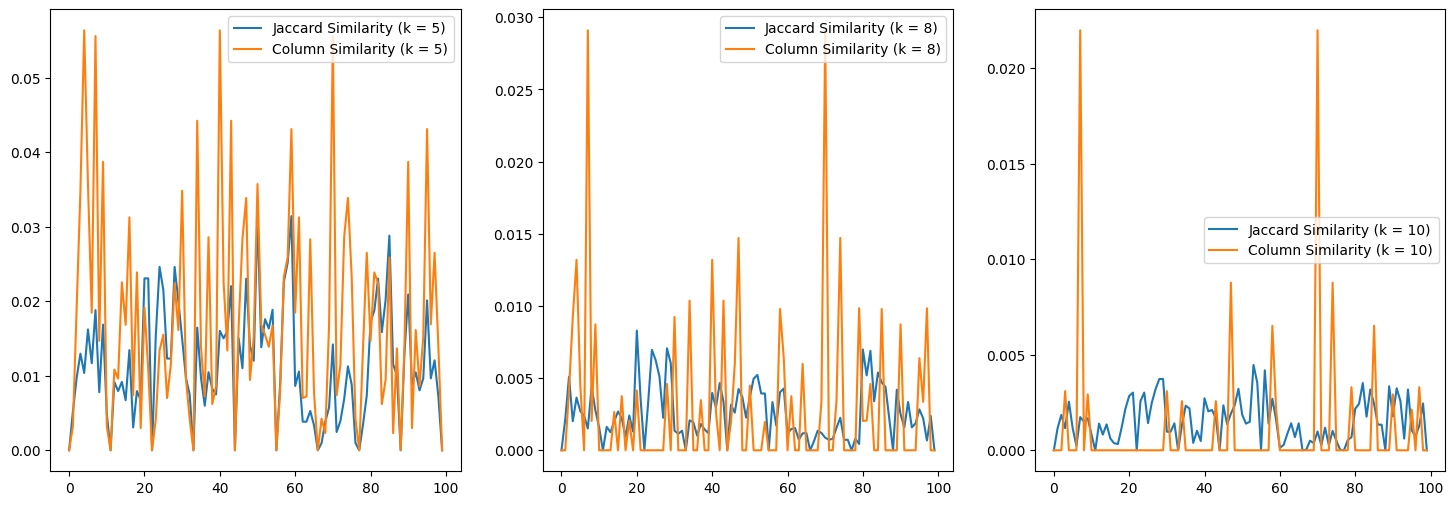

In [57]:
# Sports news
plot_jaccard_similarity(10, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 2, shingle_5_df, shingle_8_df, shingle_10_df)

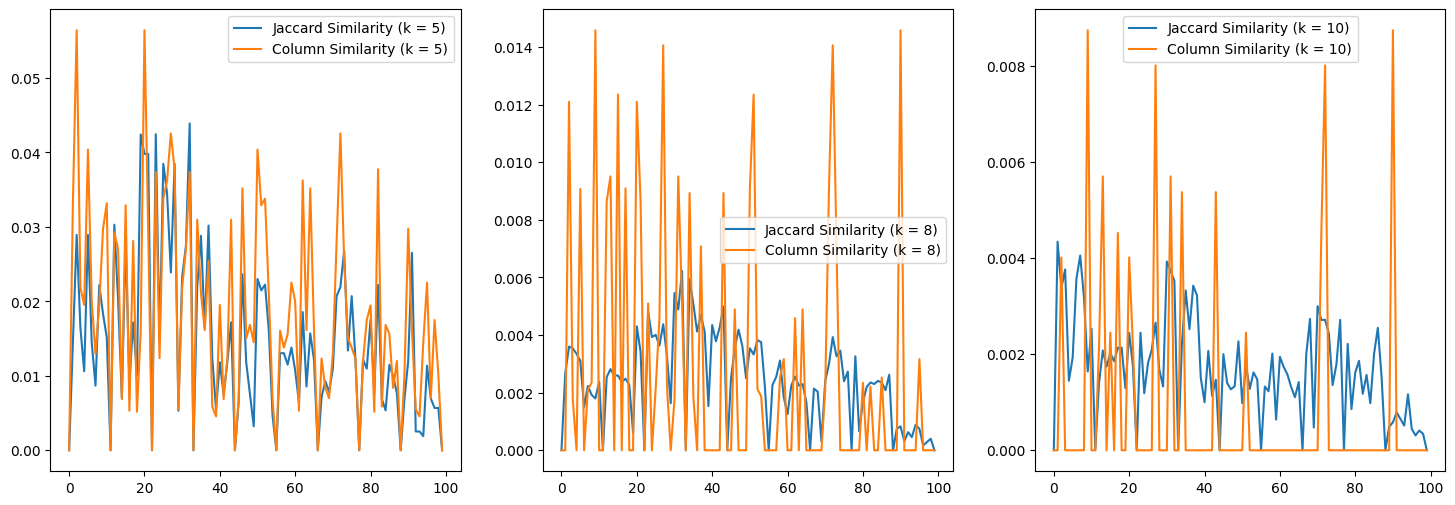

In [58]:
# Business news
plot_jaccard_similarity(10, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 3, shingle_5_df, shingle_8_df, shingle_10_df)

# Analysis of similarity using Jaccard cofficient using 20% retention

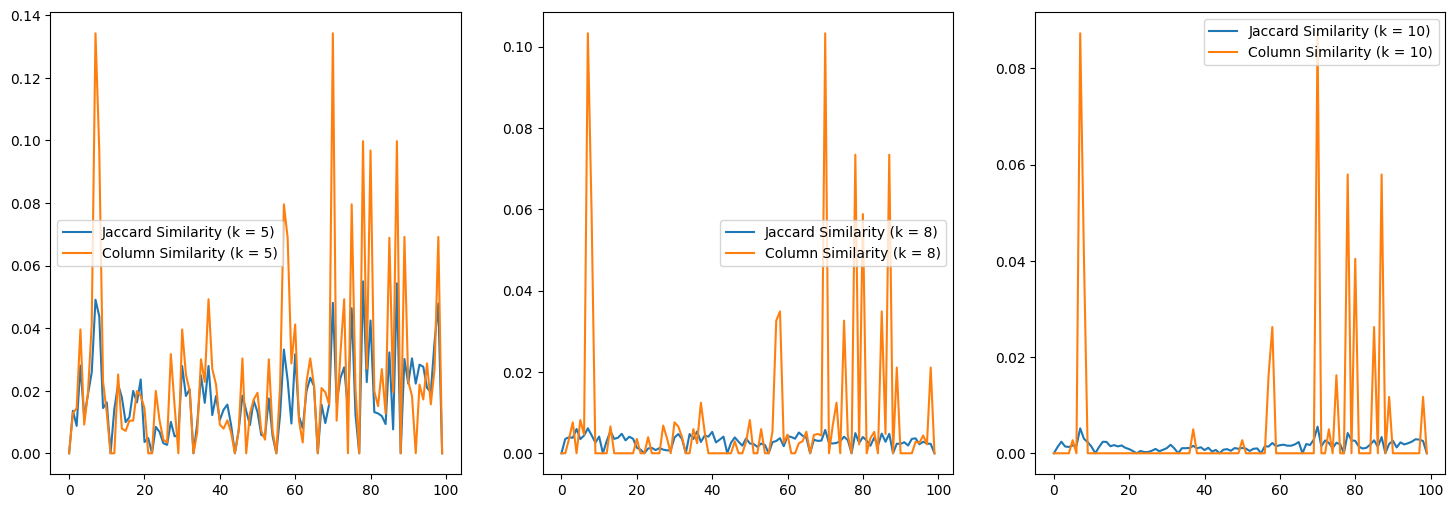

In [59]:
# World news
plot_jaccard_similarity(10, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 1, shingle_5_df, shingle_8_df, shingle_10_df)

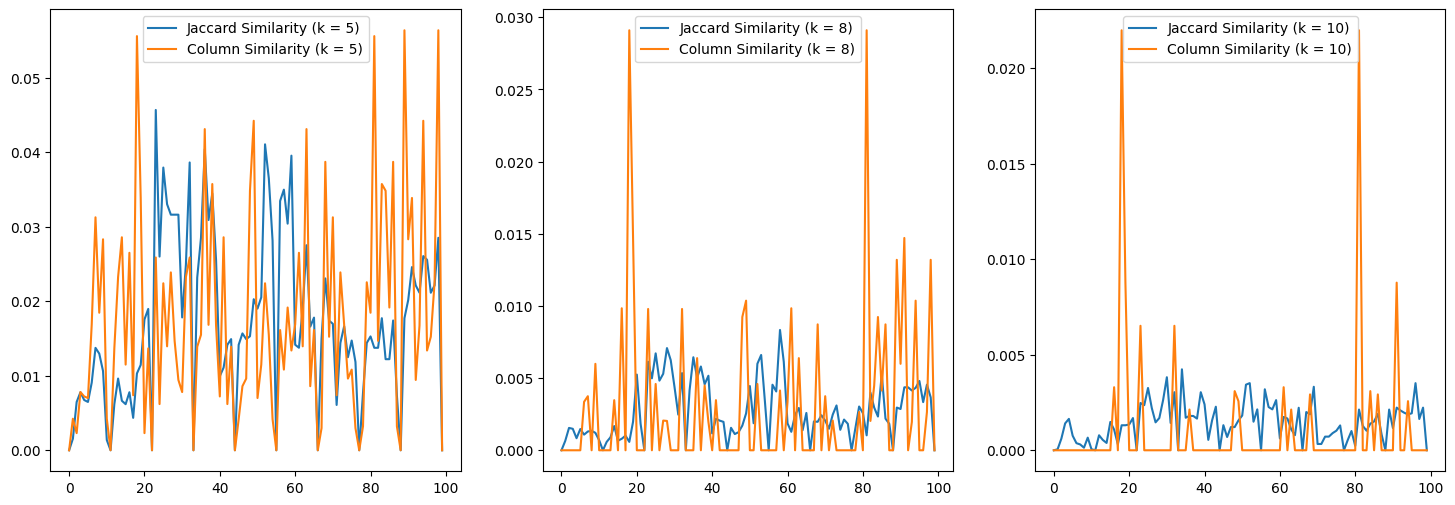

In [60]:
# Sports news
plot_jaccard_similarity(10, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 2, shingle_5_df, shingle_8_df, shingle_10_df)

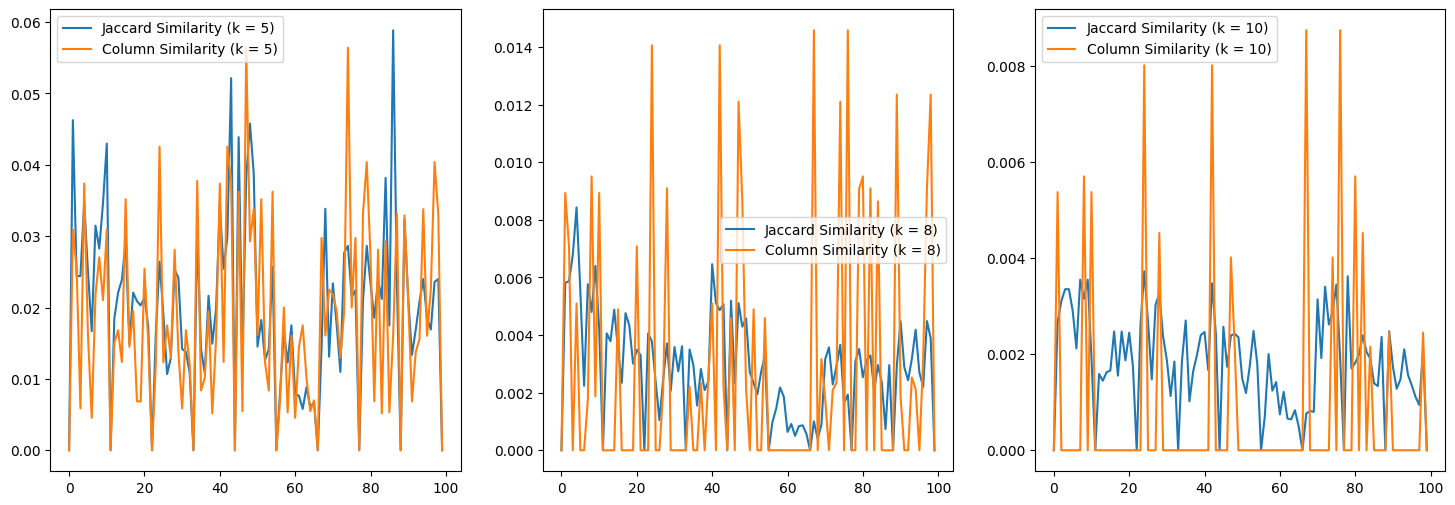

In [61]:
# Business news
plot_jaccard_similarity(10, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 3, shingle_5_df, shingle_8_df, shingle_10_df)

# Analysis of similarity using Jaccard cofficient using 30% retention

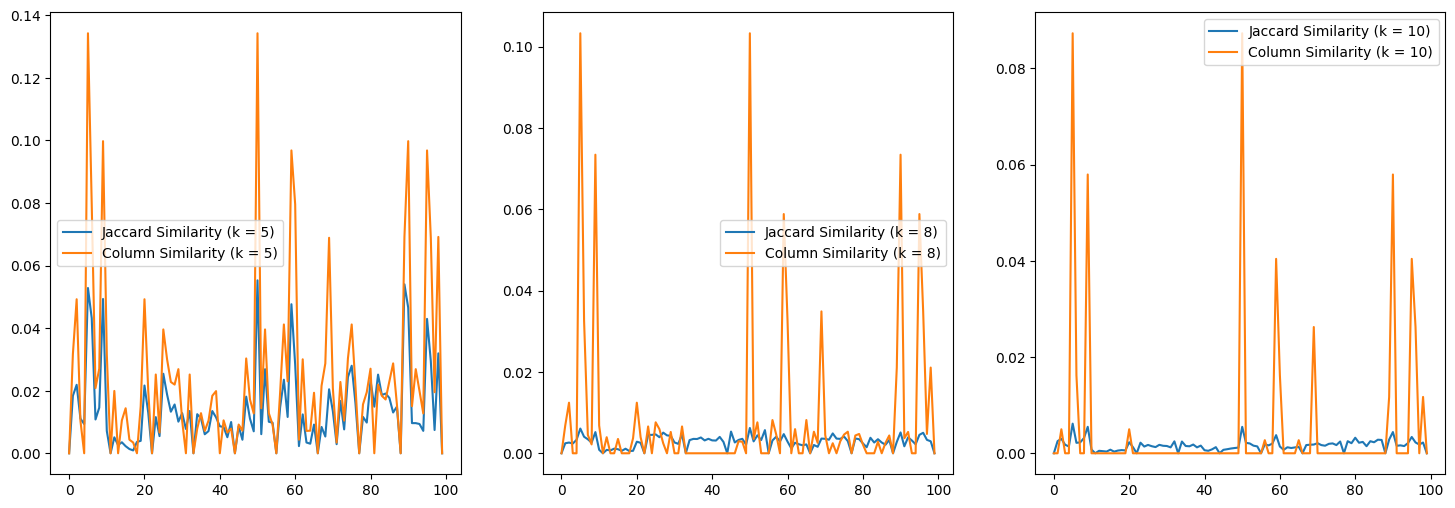

In [62]:
# World news
plot_jaccard_similarity(10, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 1, shingle_5_df, shingle_8_df, shingle_10_df)

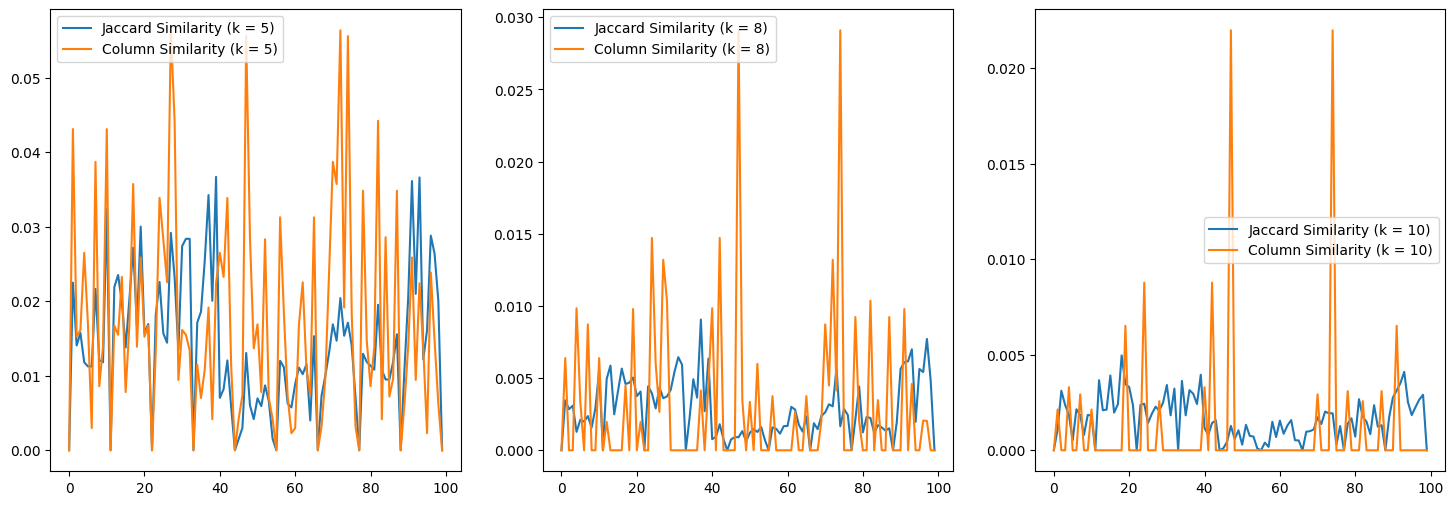

In [63]:
# Sports news
plot_jaccard_similarity(10, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 2, shingle_5_df, shingle_8_df, shingle_10_df)

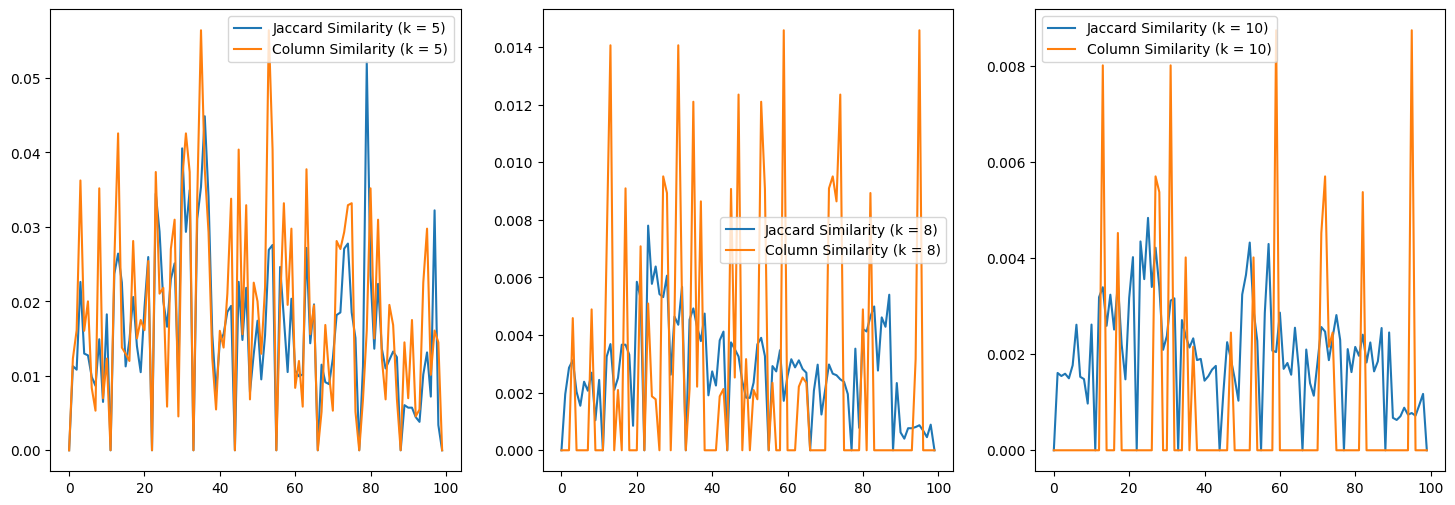

In [64]:
# Business news
plot_jaccard_similarity(10, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 3, shingle_5_df, shingle_8_df, shingle_10_df)

# 

In [65]:
def dice_similarity_column(shingle_df, i, j):
    intersection = np.sum((shingle_df[:, i] == shingle_df[:, j]) & (shingle_df[:, i] == 1))
    union = np.sum(shingle_df[:, i] == 1) + np.sum(shingle_df[:, j] == 1)

    if union == 0:
        return 0.0  # Avoid division by zero

    return 2 * intersection / union

In [66]:
def dice_similarity(signature_matrix, i, j):
    return 2 * np.sum(signature_matrix.loc[:, i] == signature_matrix.loc[:, j]) / (np.sum(signature_matrix.loc[:, i]) + np.sum(signature_matrix.loc[:, j]))

In [67]:
def plot_dice_similarity(numsize, sign_mat_5, sign_mat_8, sign_mat_10, classid, shingle_5_df, shingle_8_df, shingle_10_df):

    if classid == 1:
        random_numbers = np.random.choice(range(10), numsize, replace=False)
    elif classid == 2:
        random_numbers = np.random.choice(range(10, 20), numsize, replace=False)
    elif classid == 3:
        random_numbers = np.random.choice(range(20, 30), numsize, replace=False)
    else:
        random_numbers = np.random.choice(range(30), numsize, replace=False)

    dice_similarity_5 = np.zeros((numsize, numsize))
    dice_similarity_8 = np.zeros((numsize, numsize))
    dice_similarity_10 = np.zeros((numsize, numsize))
    column_similarity_5 = np.zeros((numsize, numsize))
    column_similarity_8 = np.zeros((numsize, numsize))
    column_similarity_10 = np.zeros((numsize, numsize))

    for i in range(numsize):
        for j in range(numsize):
            if i != j:
                num1 = random_numbers[i]
                num2 = random_numbers[j]
                dice_similarity_5[i, j] = dice_similarity(sign_mat_5, num1, num2)*10
                dice_similarity_8[i, j] = dice_similarity(sign_mat_8, num1, num2)
                dice_similarity_10[i, j] = dice_similarity(sign_mat_10, num1, num2)
                column_similarity_5[i, j] = dice_similarity_column(shingle_5_df.to_numpy(), num1, num2)
                column_similarity_8[i, j] = dice_similarity_column(shingle_8_df.to_numpy(), num1, num2)
                column_similarity_10[i, j] = dice_similarity_column(shingle_10_df.to_numpy(), num1, num2)

    dice_similarity_5 = dice_similarity_5.flatten()
    dice_similarity_8 = dice_similarity_8.flatten()
    dice_similarity_10 = dice_similarity_10.flatten()
    column_similarity_5 = column_similarity_5.flatten()
    column_similarity_8 = column_similarity_8.flatten()
    column_similarity_10 = column_similarity_10.flatten()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    axes[0].plot(dice_similarity_5, label='Dice Similarity (k = 5)')
    axes[0].plot(column_similarity_5, label='Column Similarity (k = 5)')
    axes[0].legend()

    axes[1].plot(dice_similarity_8, label='Dice Similarity (k = 8)')
    axes[1].plot(column_similarity_8, label='Column Similarity (k = 8)')
    axes[1].legend()

    axes[2].plot(dice_similarity_10, label='Dice Similarity (k = 10)')
    axes[2].plot(column_similarity_10, label='Column Similarity (k = 10)')
    axes[2].legend()

    plt.show()

# Analysis of similarity using Dice Cofficient using 10% retention

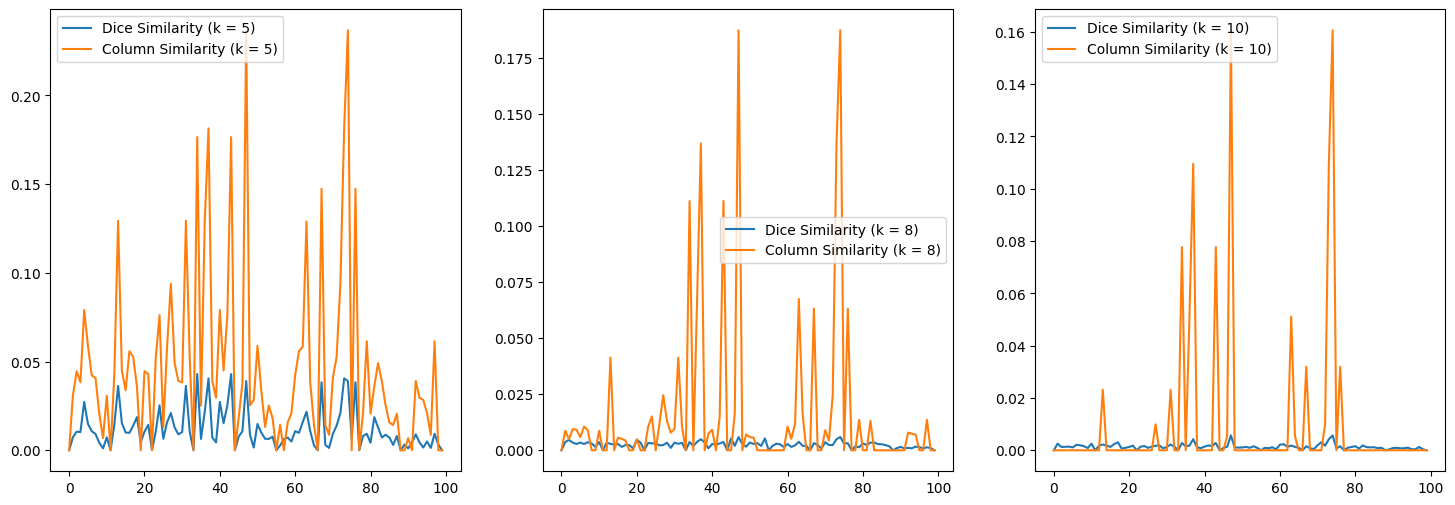

In [68]:
# World news
plot_dice_similarity(10, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 1, shingle_5_df, shingle_8_df, shingle_10_df)

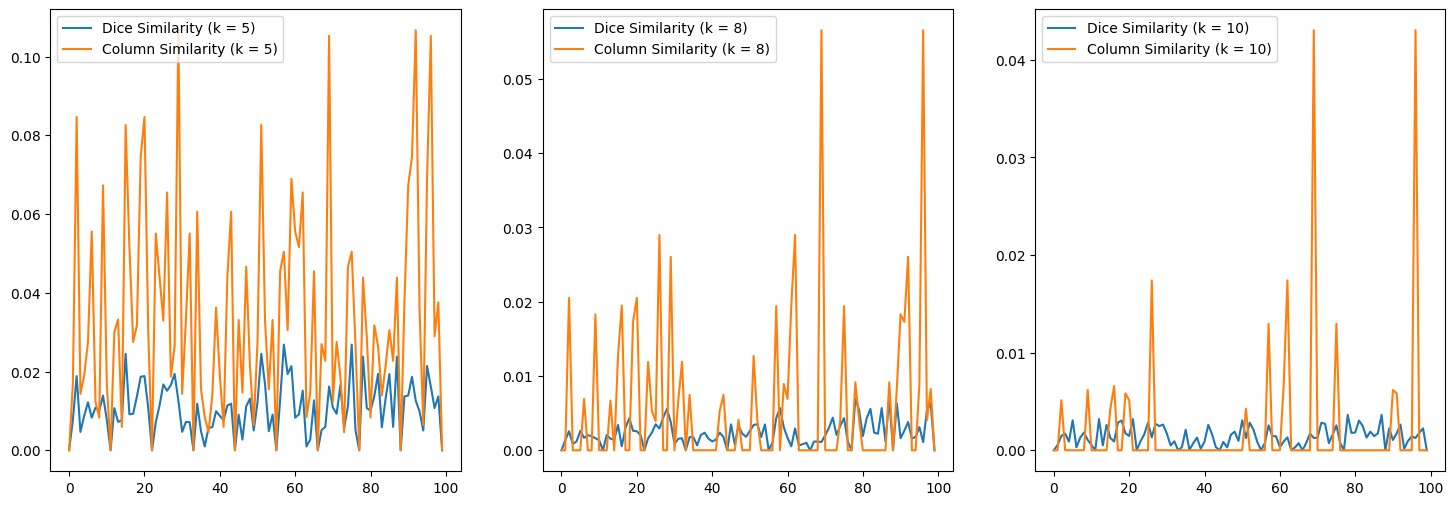

In [69]:
# Sports news
plot_dice_similarity(10, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 2, shingle_5_df, shingle_8_df, shingle_10_df)

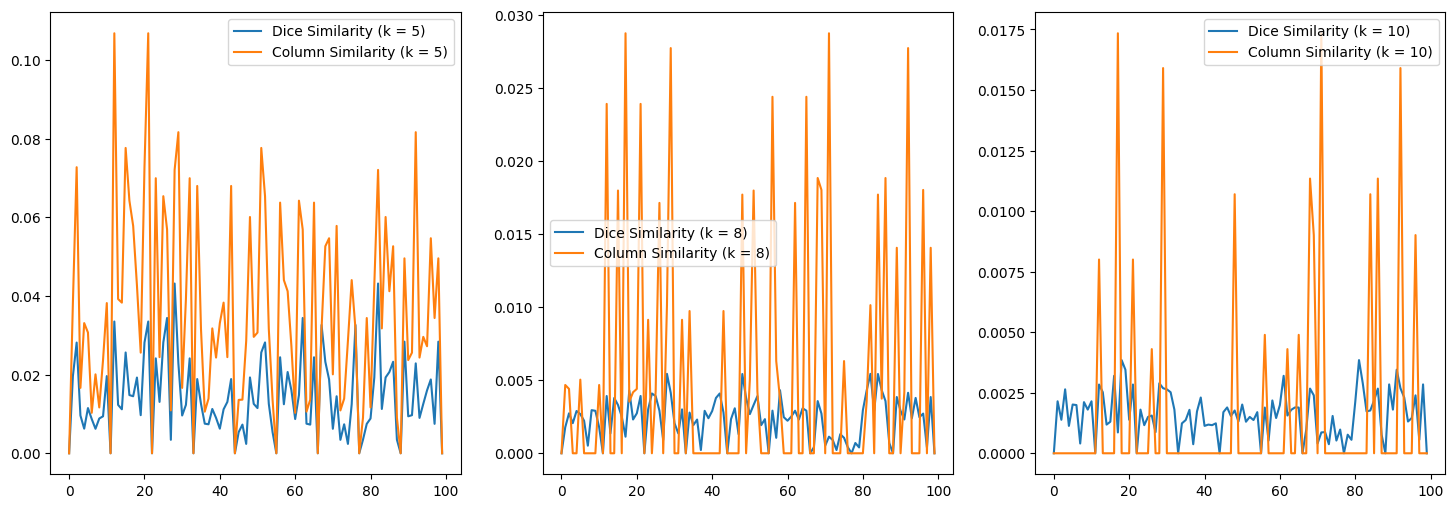

In [70]:
# Business news
plot_dice_similarity(10, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 3, shingle_5_df, shingle_8_df, shingle_10_df)

# Analysis of similarity using Dice Cofficient using 20% retention

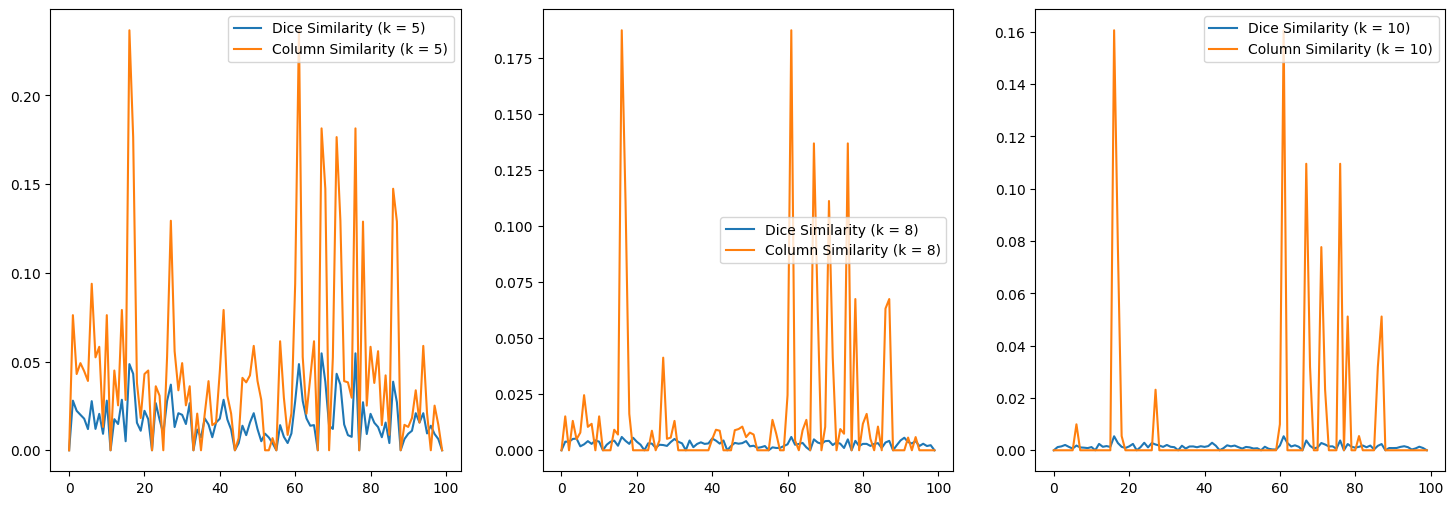

In [71]:
# World news
plot_dice_similarity(10, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 1, shingle_5_df, shingle_8_df, shingle_10_df)

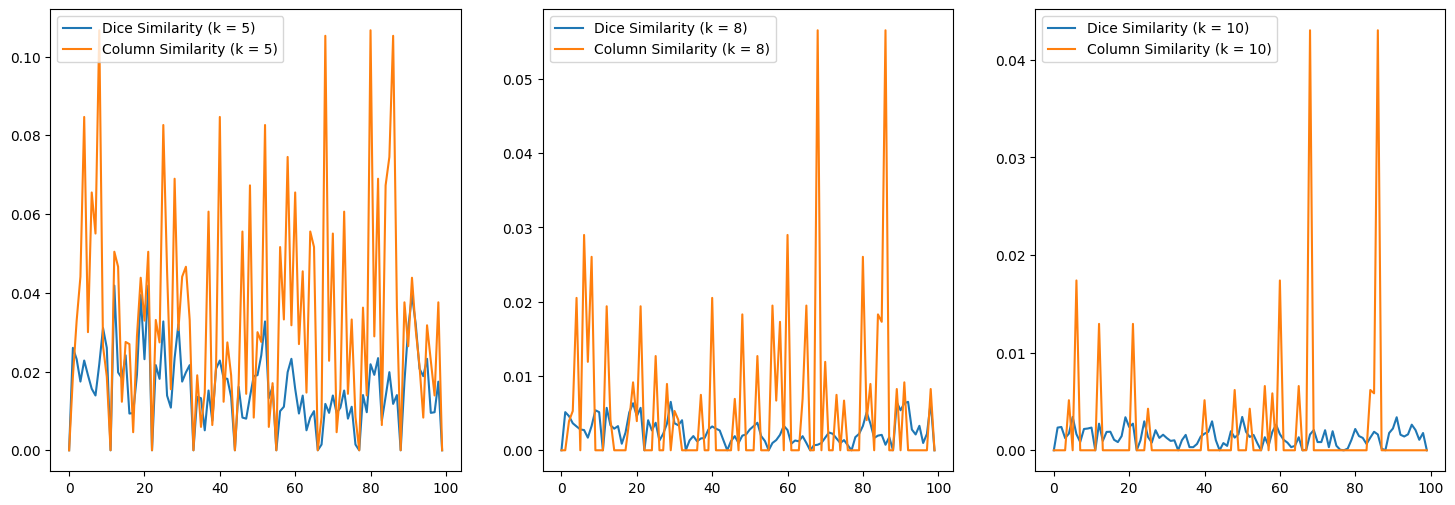

In [72]:
# Sports news
plot_dice_similarity(10, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 2, shingle_5_df, shingle_8_df, shingle_10_df)

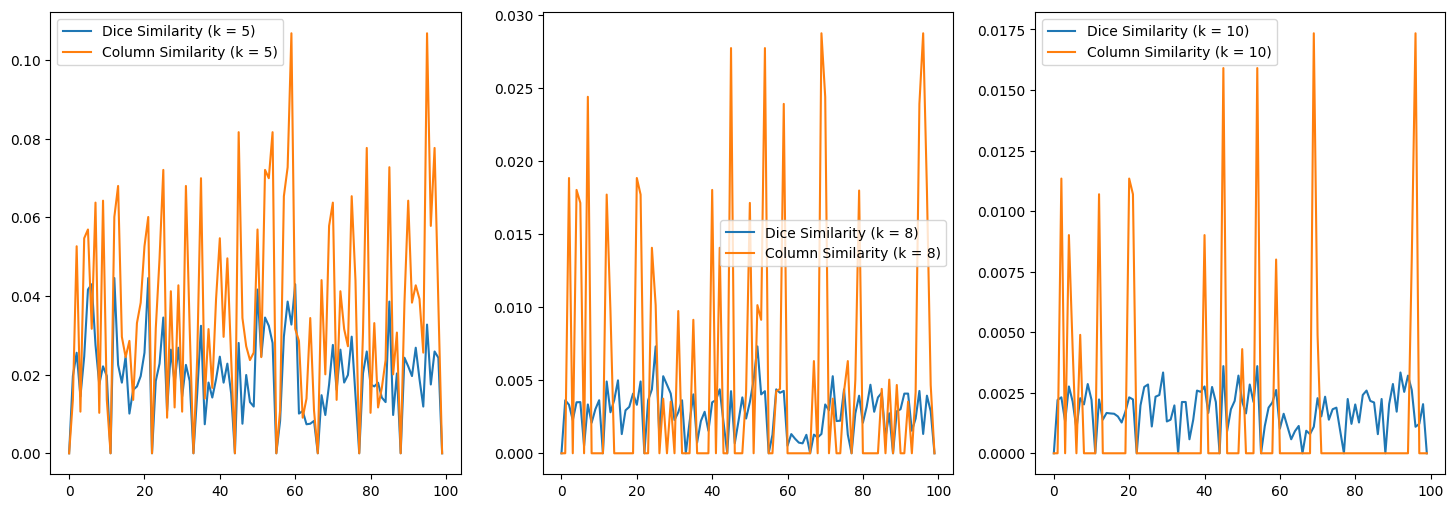

In [73]:
# Business news
plot_dice_similarity(10, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 3, shingle_5_df, shingle_8_df, shingle_10_df)

# Analysis of similarity using Dice Cofficient using 30% retention

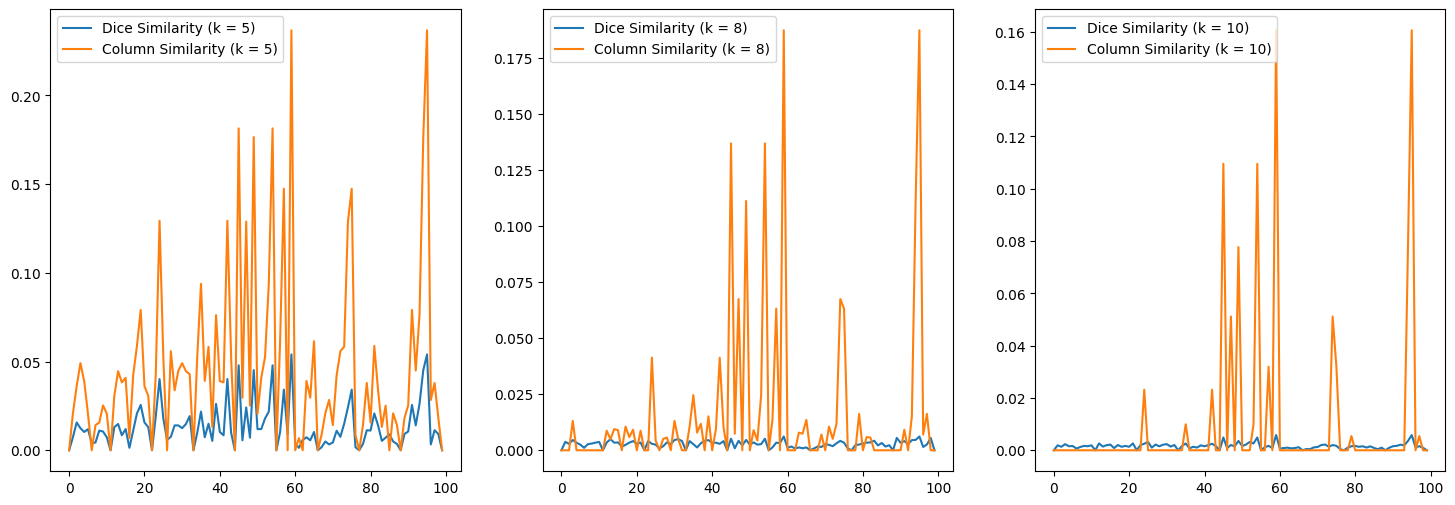

In [74]:
# World news
plot_dice_similarity(10, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 1, shingle_5_df, shingle_8_df, shingle_10_df)

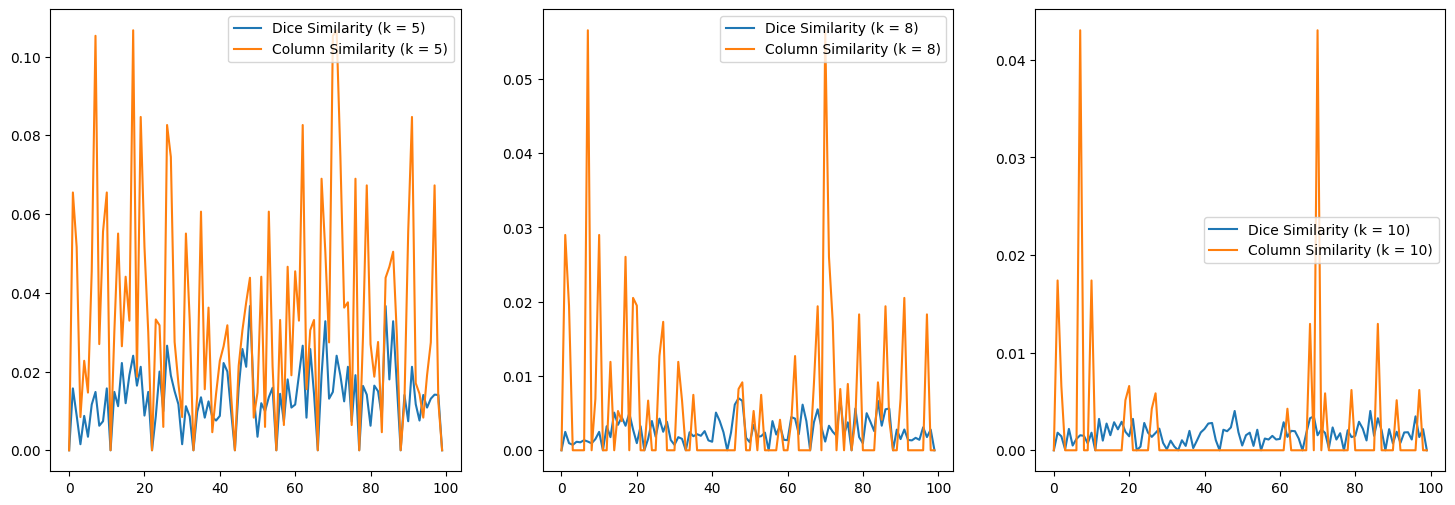

In [75]:
# Sports news
plot_dice_similarity(10, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 2, shingle_5_df, shingle_8_df, shingle_10_df)

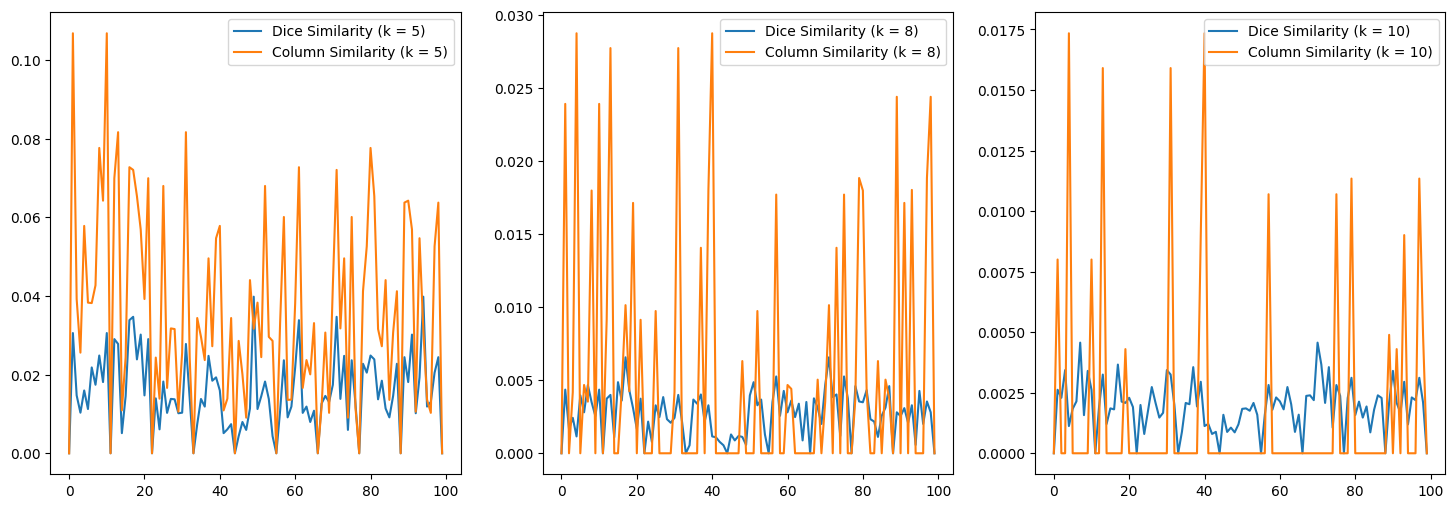

In [76]:
# Business news
plot_dice_similarity(10, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 3, shingle_5_df, shingle_8_df, shingle_10_df)

# Analysis for all documents at once using Jaccard Similarity

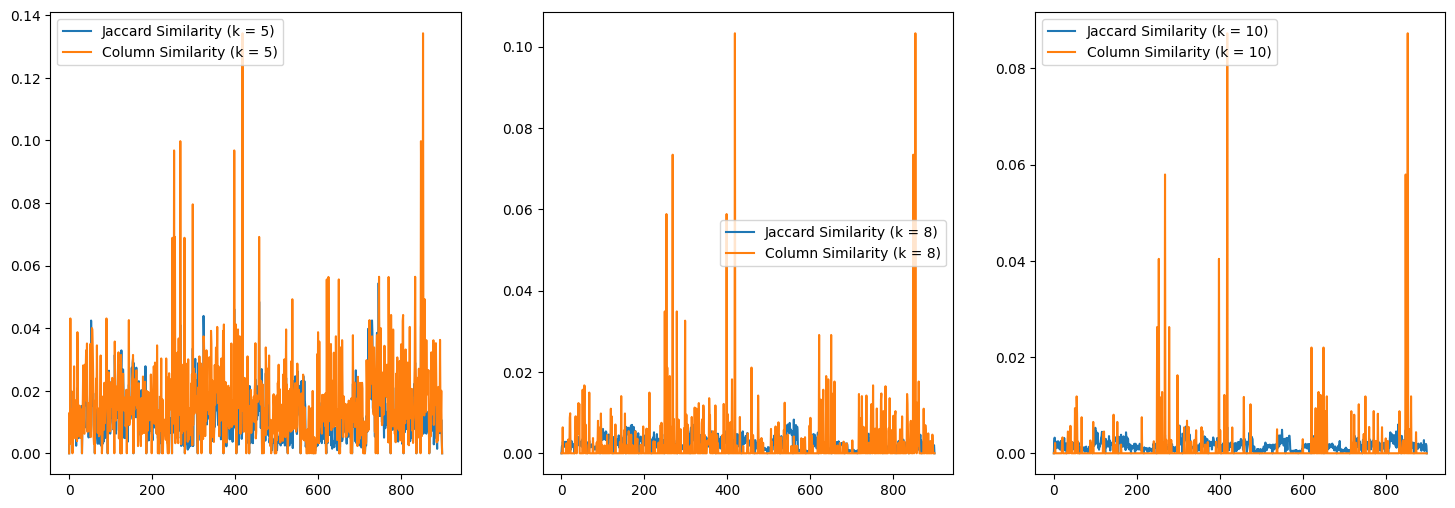

In [77]:
plot_jaccard_similarity(30, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 4, shingle_5_df, shingle_8_df, shingle_10_df)

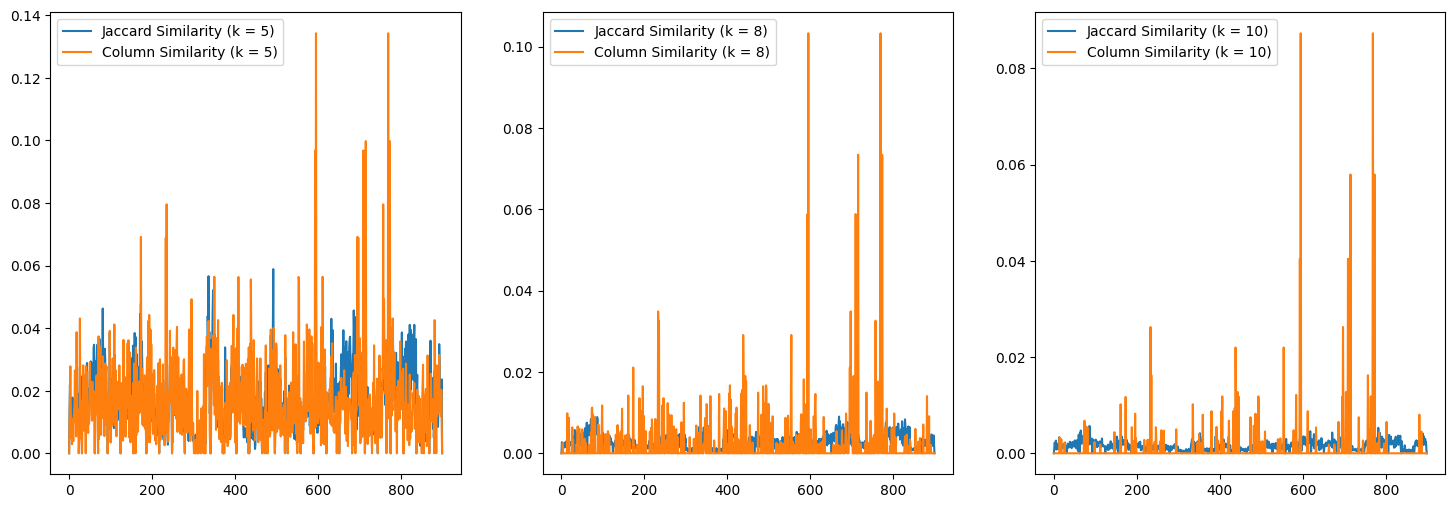

In [78]:
plot_jaccard_similarity(30, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 4, shingle_5_df, shingle_8_df, shingle_10_df) #20 retention

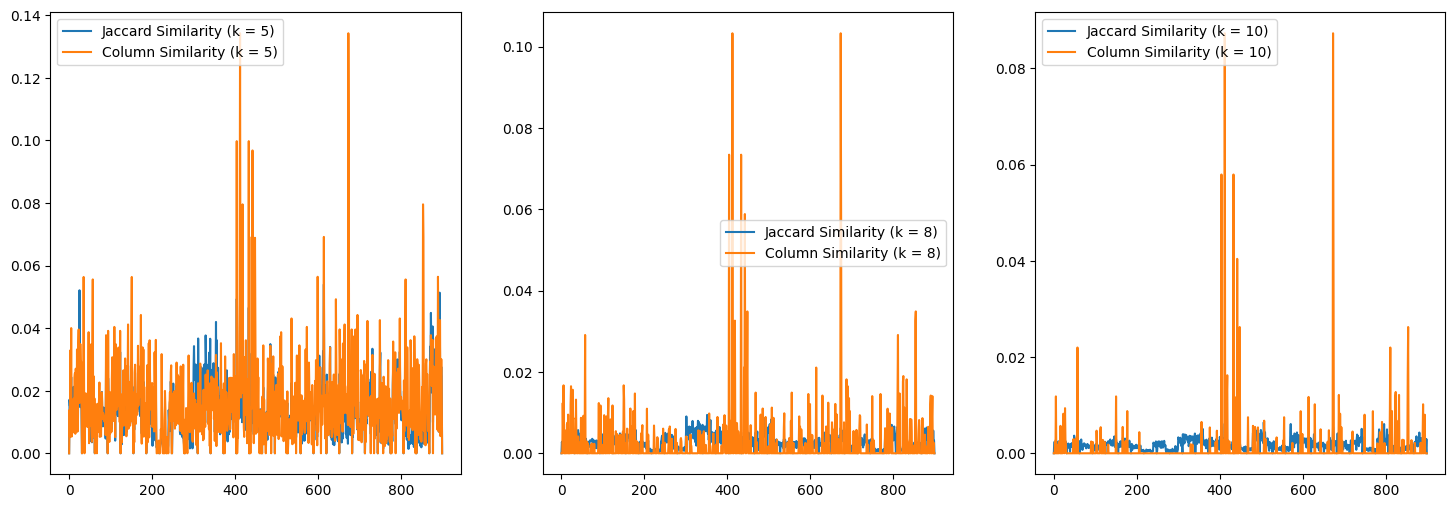

In [79]:
plot_jaccard_similarity(30, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 4, shingle_5_df, shingle_8_df, shingle_10_df)   # 30 retention

# Analysis for all documents at once using Dice Similarity

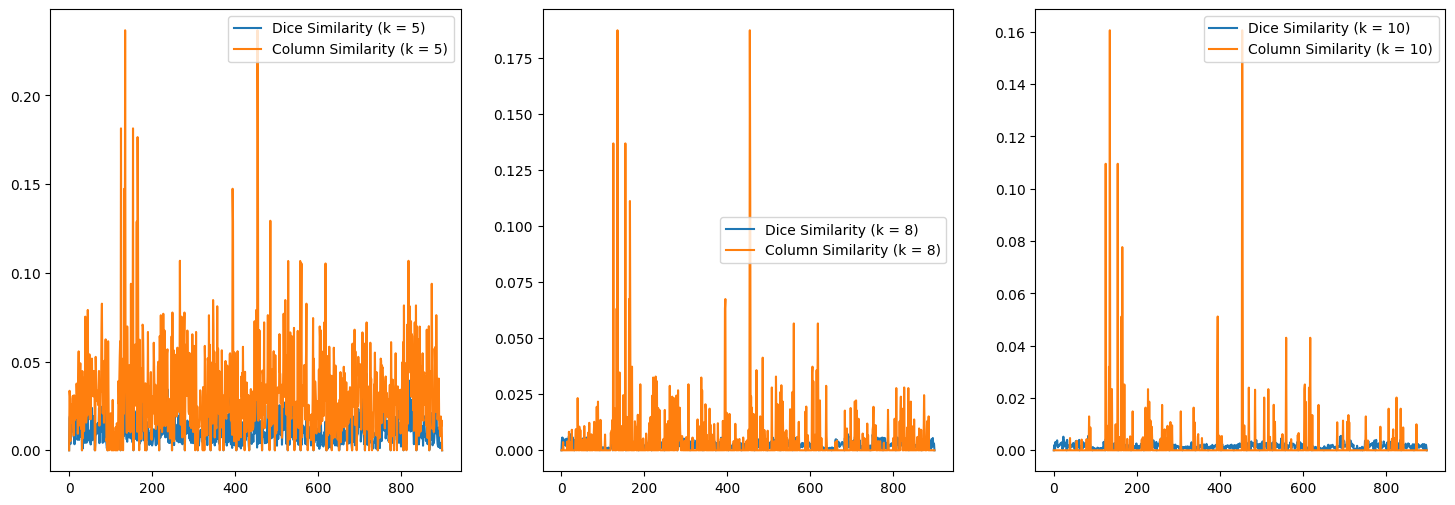

In [80]:
plot_dice_similarity(30, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 4, shingle_5_df, shingle_8_df, shingle_10_df)

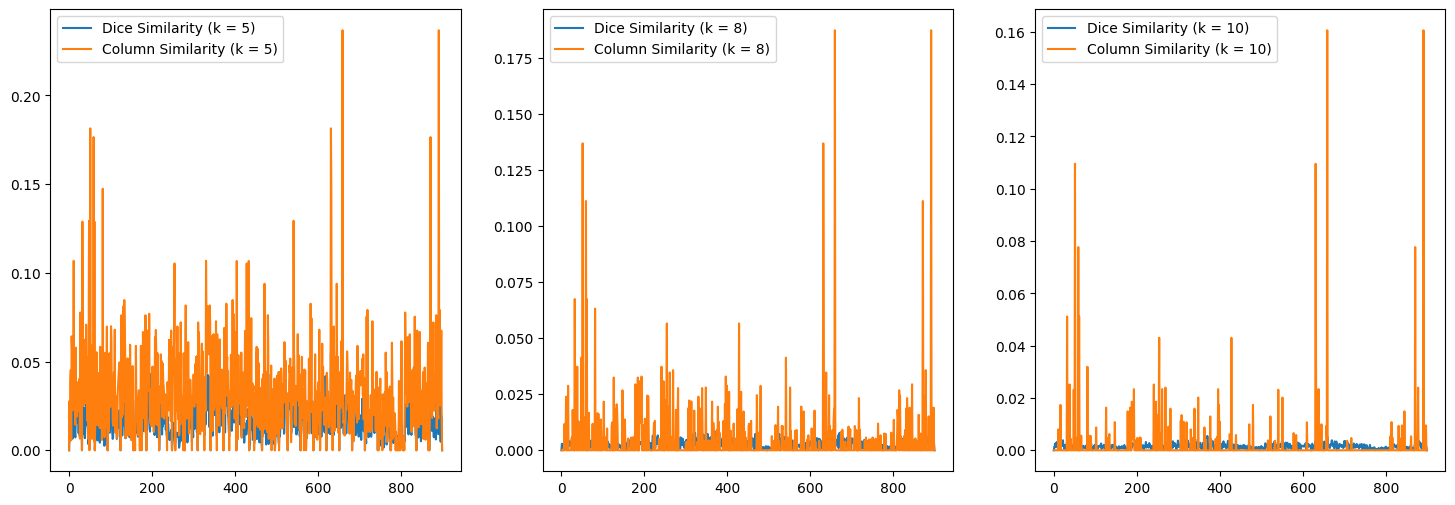

In [81]:
plot_dice_similarity(30, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 4, shingle_5_df, shingle_8_df, shingle_10_df)

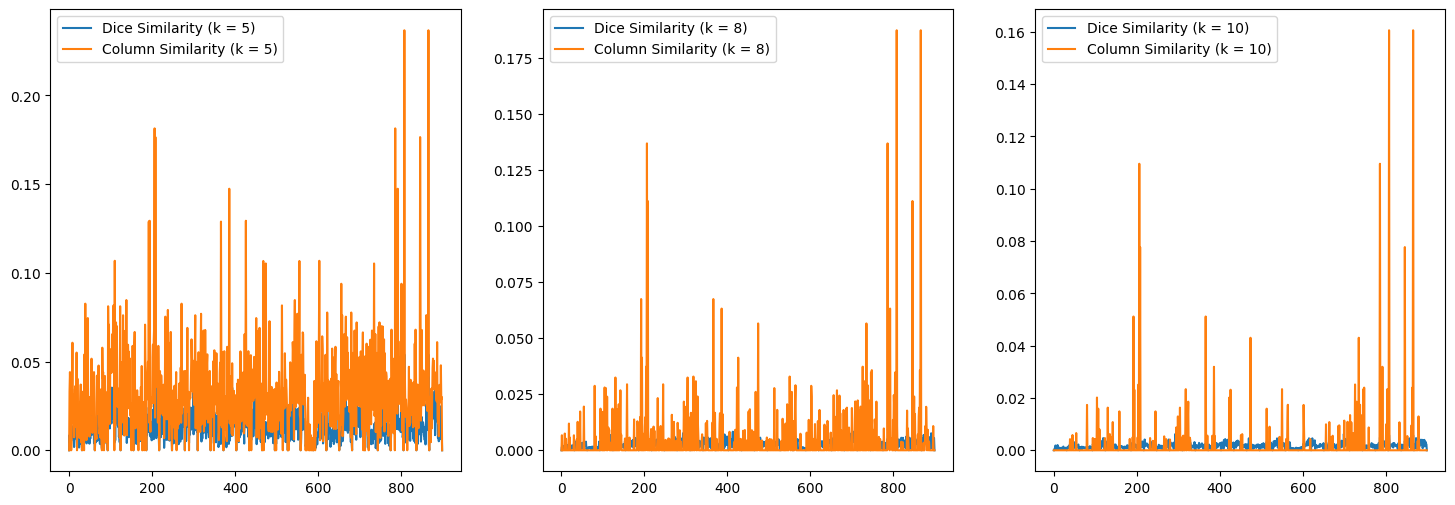

In [82]:
plot_dice_similarity(30, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 4, shingle_5_df, shingle_8_df, shingle_10_df)

# Jaccard Similarity Values

In [ ]:
similarity_matrix